# **EDA**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import scipy.stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from scipy.stats import chisquare, poisson

# I. Import data

In [ ]:
data = pd.read_parquet('HFEA_full.parquet')

In [ ]:
data.shape

(1376454, 96)

# II. Basic Preprocessings

- Filtering (using only 2016 data)
- Missing values
- Encodings / Dummifications

**NOTE**: None of these preprocessings use statistics from the entire dataset to modify / engineer features. Therefore, there is no data leakage despite the processings being directly applied to the entire data. This was done out of convenience.

### II. 1. Filtering

In [ ]:
HFEA_1999_2016 = data.copy()

# Keep only the years 2015 and 2016 
HFEA_2015_2016 = HFEA_1999_2016[HFEA_1999_2016['YEAR_OF_TREATMENT'].isin([2016])]
print('The number of cycles in 2016 is '+str(HFEA_2015_2016.shape[0]))

original_data_rows = HFEA_2015_2016.shape[0]

# Remove surrogate cases
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[(HFEA_2015_2016['PATIENT_ACTING_AS_SURROGATE'] == 0)]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} surrogate cases. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Remove donated eggs and donated embryos
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[(HFEA_2015_2016['EGG_SOURCE'] == 'Patient')]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} cases with donated eggs and embryos. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Filter data to only keep patients currently undergoing IVF
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[(HFEA_2015_2016['MAIN_REASON_FOR_PRODUCING_EMBROYS_STORING_EGGS'] == 'Treatment Now ')]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} patients not undergoing treatment in this cycle. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Remove the ICSI:Unknown, IVF:Unknown, ICSI / BLASTOCYST, FER, ICSI / AH categories
    # Group the IVF:IVF with IVF
    # Group the ICSI:ICSI, ICSI:IVF, and IVF:ICSI with ICSI
before_remove_rows = HFEA_2015_2016.shape[0]
replace_values = {'ICSI:ICSI': 'ICSI', 'IVF:IVF': 'IVF', 'IVF:ICSI': 'ICSI', 'ICSI:IVF': 'ICSI'}
HFEA_2015_2016['SPECIFIC_TREATMENT_TYPE'] = HFEA_2015_2016['SPECIFIC_TREATMENT_TYPE'].replace(replace_values)
values_to_keep = ['IVF', 'ICSI']
HFEA_2015_2016 = HFEA_2015_2016[HFEA_2015_2016['SPECIFIC_TREATMENT_TYPE'].isin(values_to_keep)]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} patients not undergoing IVF or ICSI. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')


# Remove rows with neither Fresh nor Frozen, or both at once or problematic
before_remove_rows = HFEA_2015_2016.shape[0]
mask = ((HFEA_2015_2016['FRESH_CYCLE'] == 0) & (HFEA_2015_2016['FROZEN_CYCLE'] == 0))|((HFEA_2015_2016['FRESH_CYCLE'] == 1) & (HFEA_2015_2016['FROZEN_CYCLE'] == 1))
HFEA_2015_2016 = HFEA_2015_2016.loc[~mask]
HFEA_2015_2016['EMBRYOS_STORED_FOR_USE_BY_PATIENT'] = HFEA_2015_2016['EMBRYOS_STORED_FOR_USE_BY_PATIENT'].astype(float).astype('int64')
HFEA_2015_2016 = HFEA_2015_2016.loc[~((HFEA_2015_2016['EMBRYOS_STORED_FOR_USE_BY_PATIENT'] > 1) & (HFEA_2015_2016['EMBRYOS_TRANSFERED'] == 0))]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} cases with neither Fresh nor Frozen, or both at once. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Remove Frozen cycles
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[HFEA_2015_2016['FRESH_CYCLE'] == 1]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} Frozen cycles. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')
print('There are '+str(HFEA_2015_2016.shape[0])+' FRESH cycles in the dataset.')

# Clean necessary for further processing
HFEA_2015_2016['FRESH_EGGS_COLLECTED'] =  HFEA_2015_2016['FRESH_EGGS_COLLECTED'].replace('> 50', 51)
HFEA_2015_2016['TOTAL_EMBRYOS_CREATED'] =  HFEA_2015_2016['TOTAL_EMBRYOS_CREATED'].replace('> 50', 51)
HFEA_2015_2016[['EMBRYOS_TRANSFERED', 'EMBRYOS_STORED_FOR_USE_BY_PATIENT', 'TOTAL_EMBRYOS_CREATED', 'FRESH_EGGS_COLLECTED']] = HFEA_2015_2016[['EMBRYOS_TRANSFERED', 'EMBRYOS_STORED_FOR_USE_BY_PATIENT', 'TOTAL_EMBRYOS_CREATED', 'FRESH_EGGS_COLLECTED']].astype('int64')

# Remove patients who had more embryos transferred or frozen than embryos created (annormality)
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[~((HFEA_2015_2016['EMBRYOS_TRANSFERED'] + HFEA_2015_2016['EMBRYOS_STORED_FOR_USE_BY_PATIENT']) > HFEA_2015_2016['TOTAL_EMBRYOS_CREATED'])]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} patients with more embryos transfered + frozen than created. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Remove patients who had more embryos created than eggs collected(annormality)
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016_cleaned = HFEA_2015_2016[~((HFEA_2015_2016['TOTAL_EMBRYOS_CREATED']) > HFEA_2015_2016['FRESH_EGGS_COLLECTED'])]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} patients with more embryos created than eggs collected. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Remove patients who had a live birth despite no eggs collected (annormality)
before_remove_rows = HFEA_2015_2016.shape[0]
HFEA_2015_2016 = HFEA_2015_2016[~((HFEA_2015_2016['FRESH_EGGS_COLLECTED'] == 0) & (HFEA_2015_2016['LIVE_BIRTH_OCCURRENCE'] == 1))]
removed_rows = before_remove_rows - HFEA_2015_2016.shape[0]
print(f'Removed {removed_rows} patients with live birth despite no eggs collected. This is {100*removed_rows/original_data_rows:.2f}% of the original data.')

# Check for duplicated rows
if HFEA_2015_2016.duplicated().any() == True:
    print('The dataset contains duplicated rows.')
else:
    print('The dataset does not contain any duplicated rows.')

# Drop irrelevant features
cols_before = HFEA_2015_2016.shape[1]
columns_to_drop = ['ROW_NUMBER', 'FRESH_CYCLE', 'FROZEN_CYCLE', 'PATIENT_ACTING_AS_SURROGATE', 'MAIN_REASON_FOR_PRODUCING_EMBROYS_STORING_EGGS',
'DONATED_EMBRYO', 'TYPE_OF_TREATMENT__IVF_OR_DI', 'EGG_SOURCE', 'EGG_DONOR_AGE_AT_REGISTRATION', 'NUMBER_OF_LIVE_BIRTHS', 'EARLY_OUTCOME', 
'NUMBER_OF_FOETAL_SACS_WITH_FETAL_PULSATION','EGGS_THAWED', 'TOTAL_EMBRYOS_THAWED',
'FRESH_EGGS_STORED', 'TOTAL_EGGS_MIXED', 'EGGS_MIXED_WITH_PARTNER_SPERM', 'EGGS_MIXED_WITH_DONOR_SPERM',
'EGGS_MICROINJECTED', 'EMBRYOS_FROM_EGGS_MICROINJECTED', 'EMBRYOS_FROM_EGGS_MICROINJECTED_STORED_FOR_USE_BY_PATIENT',
'DATE_OF_EGG_COLLECTION', 'DATE_OF_EGG_THAWING', 'DATE_OF_EGG_MIXING', 'DATE_OF_EMBRYO_THAWING', 'DATE_OF_EMBRYO_TRANSFER', 
'ELECTIVE_SINGLE_EMBRYO_TRANSFER', 'EMBRYOS_TRANSFERED_FROM_EGGS_MICROINJECTED', 'EMBRYOS_TRANSFERED_FROM_EGGS_MICROINJECTED', 
'YEAR_OF_TREATMENT', 'EMBRYOS_STORED_FOR_USE_BY_PATIENT']

HFEA_2015_2016 = HFEA_2015_2016.drop(columns=columns_to_drop)
HFEA_2015_2016 = HFEA_2015_2016.drop(columns=HFEA_2015_2016.filter(regex='HEART').columns)
removed_cols = cols_before - HFEA_2015_2016.shape[1]
print(f'Removed {removed_cols} columns.')

print(f'The number of FRESH, exploitable cycles from 2016 is {HFEA_2015_2016.shape[0]}')
print(f'This represents {100*HFEA_2015_2016.shape[0]/original_data_rows:.2f}% of the original data.')

The number of cycles in 2016 is 81443
Removed 5678 surrogate cases. This is 6.97% of the original data.
Removed 3800 cases with donated eggs and embryos. This is 4.67% of the original data.
Removed 8529 patients not undergoing treatment in this cycle. This is 10.47% of the original data.
Removed 14509 patients not undergoing IVF or ICSI. This is 17.81% of the original data.
Removed 1906 cases with neither Fresh nor Frozen, or both at once. This is 2.34% of the original data.
Removed 4983 Frozen cycles. This is 6.12% of the original data.
There are 42038 FRESH cycles in the dataset.
Removed 13 patients with more embryos transfered + frozen than created. This is 0.02% of the original data.
Removed 0 patients with more embryos created than eggs collected. This is 0.00% of the original data.
Removed 31 patients with live birth despite no eggs collected. This is 0.04% of the original data.
The dataset does not contain any duplicated rows.
Removed 54 columns.
The number of FRESH, exploitable

In [ ]:
HFEA_2015_2016['SPERM_DONOR_AGE_AT_REGISTRATION'].value_counts()

Between 21 and 25    754
Between 26 and 30    538
Between 31 and 35    517
Between 36 and 40    467
Between 41 and 45    252
<= 20                113
999                   60
Name: SPERM_DONOR_AGE_AT_REGISTRATION, dtype: int64

### II. 2. Redundant Columns and Missing Values 

In [ ]:
missing_percentage = HFEA_2015_2016.isnull().mean() * 100
missing_df = pd.DataFrame(missing_percentage, columns=['Missing Percentage'])
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)
display(missing_df.head(11))

,Missing Percentage
PGS_TREATMENT,99.766633
PGS,99.764252
DATE_PATIENT_STARTED_TRYING_TO_BECOME_PREGNANT_OR_DATE_OF_LAST_PREGNANCY,99.742820
PGD_TREATMENT,99.716626
SPERM_DONOR_AGE_AT_REGISTRATION,93.568129
LIVE_BIRTH_OCCURRENCE,73.039006
TYPE_OF_OVULATION_INDUCTION,2.012192
CAUSE_OF_INFERTILITY___PARTNER_SPERM_IMMUNOLOGICAL_FACTORS,0.000000
CAUSE_OF_INFERTILITY__CERVICAL_FACTORS,0.000000
CAUSE_OF_INFERTILITY__FEMALE_FACTORS,0.000000


In [ ]:
HFEA_2015_2016['TYPE_OF_OVULATION_INDUCTION'].value_counts()

Yes but not recorded    41148
Cetrotide                   1
Name: TYPE_OF_OVULATION_INDUCTION, dtype: int64

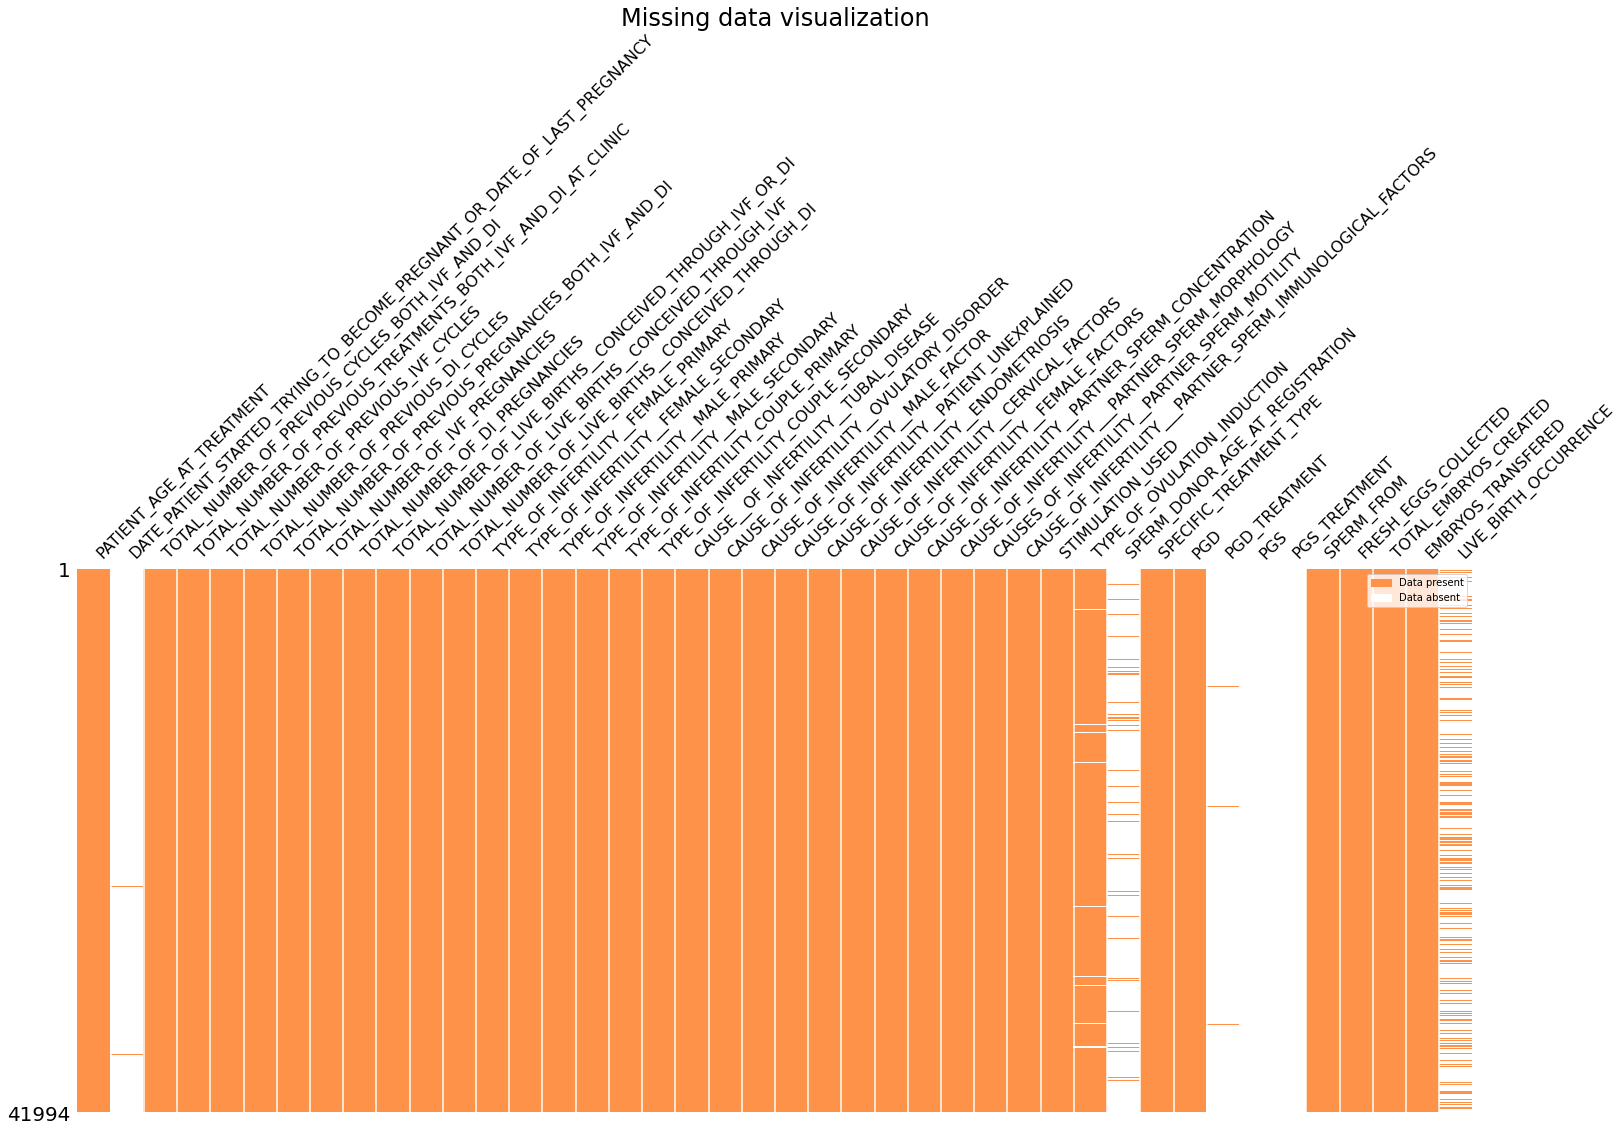

In [ ]:
# Display visualization of nulls
colours_gaia = ["#FF9249", "#382C2E", '#F0E9DE']
msno.matrix(HFEA_2015_2016, sparkline=False, color=(255/255, 146/255, 73/255))
gray_patch = mpatches.Patch(color=colours_gaia[0], label='Data present')
white_patch = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray_patch, white_patch])
plt.title('Missing data visualization', fontsize=24)
plt.savefig('missing_data_visualization.png', bbox_inches = 'tight', dpi=600)
plt.show()

In [ ]:
# Remove TYPE_OF_OVULATION_INDUCTION because this feature is constant except for 1 value or a few missing
# Remove the STARTED_TRYING feature because it is pratically empty for every cycle
# Remove PGD_TREATMENT and PGS_TREATMENT because their information is redundant
HFEA_2015_2016_cleaned = HFEA_2015_2016.drop(columns=['TYPE_OF_OVULATION_INDUCTION', 
'DATE_PATIENT_STARTED_TRYING_TO_BECOME_PREGNANT_OR_DATE_OF_LAST_PREGNANCY', 'PGD_TREATMENT', 'PGS_TREATMENT'])

# For SPERM_DONOR_AGE, there are too few observations for each of the values:
    # In TRAIN batch:
    # 0    32792
    # 1       96
    # 2      634
    # 3      456
    # 4      429
    # 5      385
    # 6      215
# Thus this feature will not be kept. Instead the existing feature SPERM_FROM will be used to capture this information.
HFEA_2015_2016_cleaned = HFEA_2015_2016_cleaned.drop(columns=['SPERM_DONOR_AGE_AT_REGISTRATION'])

# For PGS:
    # Fill miising values with zeros because this is what they are
    # Feature is extremely sparse and will thus be combined with PGD
HFEA_2015_2016_cleaned['PGS'] = HFEA_2015_2016_cleaned['PGS'].fillna(0)
HFEA_2015_2016_cleaned['SCREENING'] = HFEA_2015_2016_cleaned['PGS'] + HFEA_2015_2016_cleaned['PGD']
HFEA_2015_2016_cleaned['SCREENING'] = HFEA_2015_2016_cleaned['SCREENING'].clip(upper=1)
HFEA_2015_2016_cleaned = HFEA_2015_2016_cleaned.drop(['PGS', 'PGD'], axis=1)

# Fill nans in LIVE_BIRTH_OCCURRENCE with zeros because this is what they are
HFEA_2015_2016_cleaned['LIVE_BIRTH_OCCURRENCE'] = HFEA_2015_2016_cleaned['LIVE_BIRTH_OCCURRENCE'].fillna(0)

# Check for constant features
constant_features = HFEA_2015_2016_cleaned.columns[HFEA_2015_2016_cleaned.nunique() <= 1]
if len(constant_features) != 0:
    print("There are constant features. The following features are constant:")
    for feature in constant_features:
        print(feature)
else:
    print('There are no constant features.')

There are constant features. The following features are constant:
CAUSE_OF_INFERTILITY__CERVICAL_FACTORS
CAUSE_OF_INFERTILITY__FEMALE_FACTORS
CAUSE_OF_INFERTILITY___PARTNER_SPERM_IMMUNOLOGICAL_FACTORS


In [ ]:
# Drop the constant features
HFEA_2015_2016_cleaned = HFEA_2015_2016_cleaned.drop(['CAUSE_OF_INFERTILITY__CERVICAL_FACTORS', 'CAUSE_OF_INFERTILITY__FEMALE_FACTORS', 
'CAUSE_OF_INFERTILITY___PARTNER_SPERM_IMMUNOLOGICAL_FACTORS'], axis=1)

In [ ]:
HFEA_2015_2016_cleaned.shape

(41994, 33)

### II. 3. Encodings / Dummifications

In [ ]:
# Some variables are counts but are capped, i.e. >=5. These need to be transformed. 
# We will chose the next greatest value in the series as an approximationion.
HFEA_2015_2016_cleaned[['TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
'TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_AND_DI_AT_CLINIC',
'TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES',
'TOTAL_NUMBER_OF_PREVIOUS_DI_CYCLES']] = HFEA_2015_2016_cleaned[['TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
'TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_AND_DI_AT_CLINIC',
'TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES',
'TOTAL_NUMBER_OF_PREVIOUS_DI_CYCLES']].replace('>=5', 6)

In [ ]:
# Dummify the SPECIFIC_TREATMENT_TYPE variable
HFEA_2015_2016_cleaned = pd.get_dummies(HFEA_2015_2016_cleaned, columns=['SPECIFIC_TREATMENT_TYPE'], prefix='SPECIFIC_TREATMENT_TYPE', drop_first=True)

In [ ]:
# The variables PATIENT_AGE_AT_TREATMENT and SPERM_DONOR_AGE_AT_REGISTRATION need to be encoded and coserve their oridnal nature. 
# We simply replace categories with integers corresponding to their respective position

replace_values = {'18 - 34': 1, '35-37': 2, '38-39': 3, '40-42': 4, '43-44':5, '45-50':6}
HFEA_2015_2016_cleaned['PATIENT_AGE_AT_TREATMENT'] = HFEA_2015_2016_cleaned['PATIENT_AGE_AT_TREATMENT'].replace(replace_values)

replace_values = {'Partner': 0, 'Donor': 1, 'not assigned':0}
HFEA_2015_2016_cleaned['SPERM_FROM'] = HFEA_2015_2016_cleaned['SPERM_FROM'].replace(replace_values)

In [ ]:
# Now that all variables have been encoded, every variable can be set to the int64 type since they are either count, ordinal, or binary.
HFEA_2015_2016_cleaned = HFEA_2015_2016_cleaned.astype('int64')

In [ ]:
HFEA_2015_2016_cleaned.shape

(41994, 33)

### II. Train / Test Split

In [ ]:
# Modelling data
modelling_data = HFEA_2015_2016_cleaned.copy()

# Split the 2016 data into Train and Test
HFEA_train, HFEA_test = train_test_split(modelling_data, test_size=0.2, random_state=42)

# Print the sizes of each set
print("Train set size:", len(HFEA_train))
print("Test set size:", len(HFEA_test))

Train set size: 33595
Test set size: 8399


In [ ]:
# Colours Gaia
colours_gaia = ["#FF9249", "#382C2E", '#F0E9DE']

# Binary features
binary_features = ['TYPE_OF_INFERTILITY__FEMALE_PRIMARY',
       'TYPE_OF_INFERTILITY__FEMALE_SECONDARY',
       'TYPE_OF_INFERTILITY__MALE_PRIMARY',
       'TYPE_OF_INFERTILITY__MALE_SECONDARY',
       'TYPE_OF_INFERTILITY_COUPLE_PRIMARY',
       'TYPE_OF_INFERTILITY_COUPLE_SECONDARY',
       'CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS',
       'CAUSE_OF_INFERTILITY__PARTNER_SPERM_CONCENTRATION',
       'CAUSE_OF_INFERTILITY___PARTNER_SPERM_MORPHOLOGY',
       'CAUSES_OF_INFERTILITY__PARTNER_SPERM_MOTILITY',
       'STIMULATION_USED', 'SCREENING', 'SPERM_FROM', 'SPECIFIC_TREATMENT_TYPE_IVF']

# Ordinal features
ordinal_features = ['PATIENT_AGE_AT_TREATMENT']

# Count features
count_features = ['TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
       'TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_AND_DI_AT_CLINIC',
       'TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES',
       'TOTAL_NUMBER_OF_PREVIOUS_DI_CYCLES',
       'TOTAL_NUMBER_OF_PREVIOUS_PREGNANCIES_BOTH_IVF_AND_DI',
       'TOTAL_NUMBER_OF_IVF_PREGNANCIES', 'TOTAL_NUMBER_OF_DI_PREGNANCIES',
       'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF_OR_DI',
       'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF',
       'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI']


# Target features
target_features = ['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'EMBRYOS_TRANSFERED', 'LIVE_BIRTH_OCCURRENCE']

## Distributions

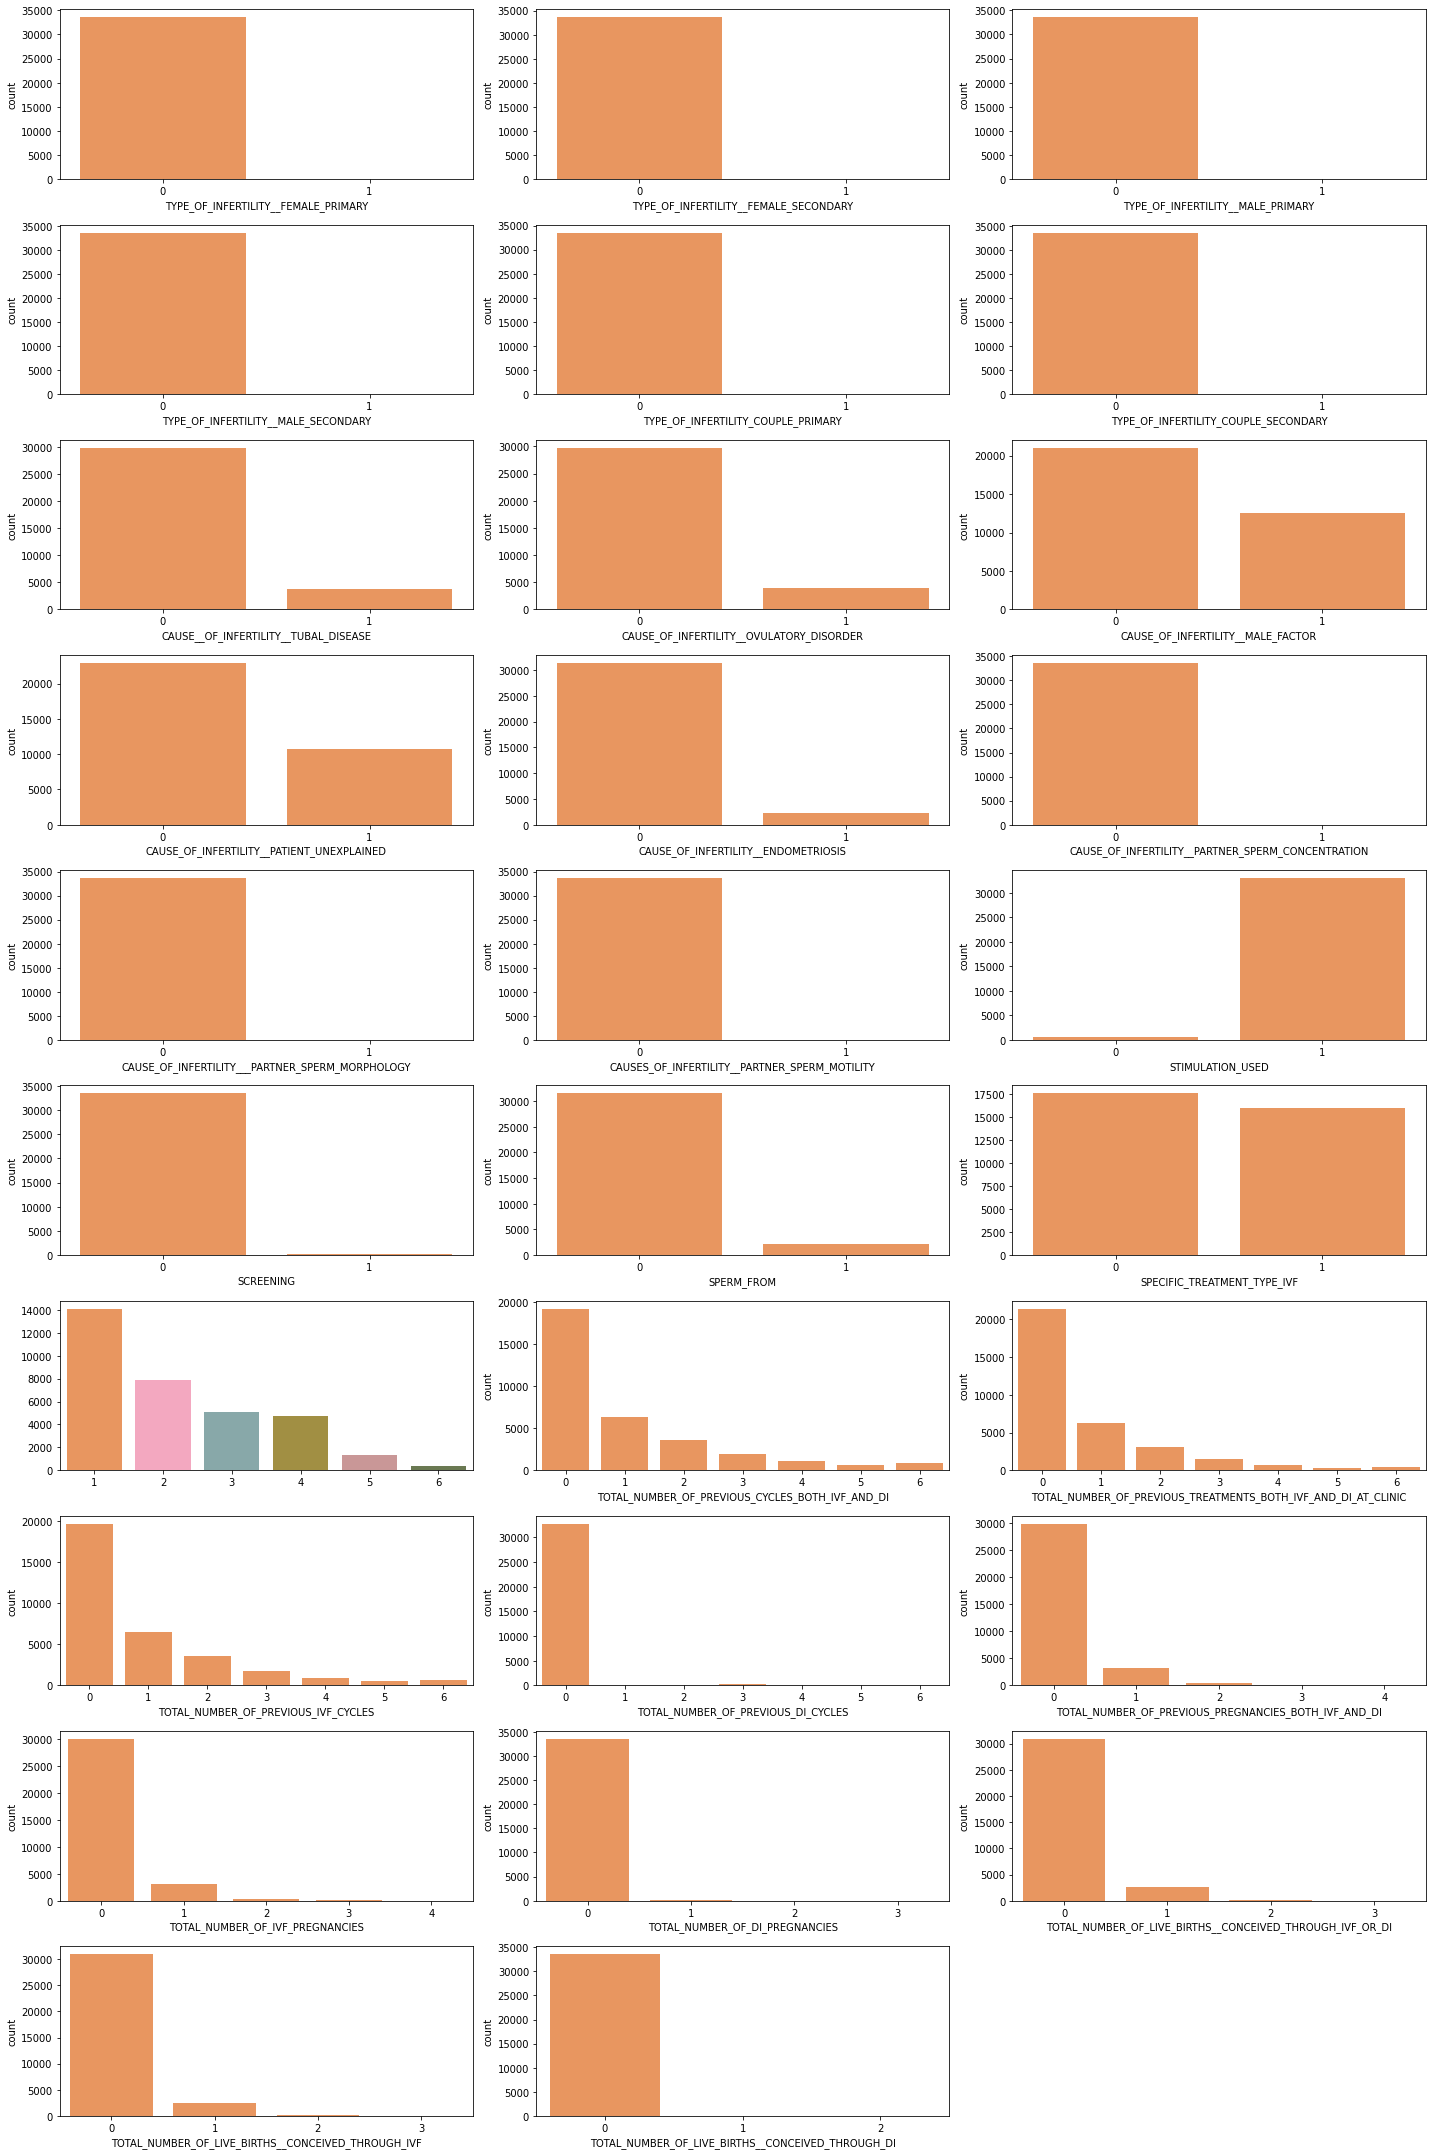

In [ ]:
predictors = binary_features + ordinal_features + count_features

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(20, 30))  # adjust this based on how many variables you have
axs = axs.flatten()  # to iterate over it in one dimension

gaia_orange = (1, 0.5725, 0.2863)
colours_gaia = [(1, 0.5725, 0.2863), (1, 155/255, 188/255), (130/255, 173/255, 174/255), (177/255, 153/255, 51/255), 
(127/155, 143/255, 143/255), (108/255, 128/255, 75/255)]

for i, var in enumerate(predictors):
    if var in binary_features:
        sns.countplot(x=var, data=HFEA_train, ax=axs[i], color=gaia_orange)
    elif var in ordinal_features:
        sns.barplot(x=HFEA_train[var].value_counts().index, y=HFEA_train[var].value_counts().values, ax=axs[i], palette=colours_gaia)
    elif var in count_features:
        sns.countplot(x=var, data=HFEA_train, ax=axs[i], color=gaia_orange)

# remove the empty plots
for i in range(len(predictors), len(axs)):
    fig.delaxes(axs[i])

plt.savefig('predictor_distributions.png', bbox_inches = 'tight', dpi=600)
plt.tight_layout()
plt.show()

## Correlations

In [ ]:
def compute_correlation_matrix(df, binary_features, ordinal_features, count_features):
    # Initialize an empty DataFrame to store the correlations
    correlation_df = pd.DataFrame(index=df.columns, columns=df.columns)

    columns = binary_features + ordinal_features + count_features
    
    # Loop over the DataFrame columns
    for col1 in columns:
        for col2 in columns:
            # If both variables are binary, use Pearson's correlation (= Phi coeffcient)
            if col1 in binary_features and col2 in binary_features:
                correlation, _ = scipy.stats.pearsonr(df[col1], df[col2])
            # If one variable is binary and the other is ordinal, use Kendall's Tau
            elif (col1 in binary_features and col2 in ordinal_features) or \
                 (col2 in binary_features and col1 in ordinal_features):
                correlation, _ = scipy.stats.kendalltau(df[col1], df[col2])
            # If one variable is binary and the other is count, use Point-Biserial
            elif (col1 in binary_features and col2 in count_features) or \
                 (col2 in binary_features and col1 in count_features):
                correlation, _ = scipy.stats.pointbiserialr(df[col1], df[col2])
            # If one variable is ordinal and the other is count, use Spearman
            elif (col1 in ordinal_features and col2 in count_features) or \
                 (col2 in ordinal_features and col1 in count_features):
                correlation, _ = scipy.stats.spearmanr(df[col1], df[col2])
            # If both variables are ordinal or both are count, use Spearman's correlation
            else:
                correlation, _ = scipy.stats.spearmanr(df[col1], df[col2])
            
            # Store the computed correlation in the DataFrame
            #correlation_df.loc[col1, col2] = correlation

            # Store the computed correlation in the DataFrame
            correlation_df.loc[col1, col2] = np.abs(correlation)

    correlation_df = correlation_df.dropna(axis=0, how='all')
    correlation_df = correlation_df.dropna(axis=1, how='all')
    
    return correlation_df

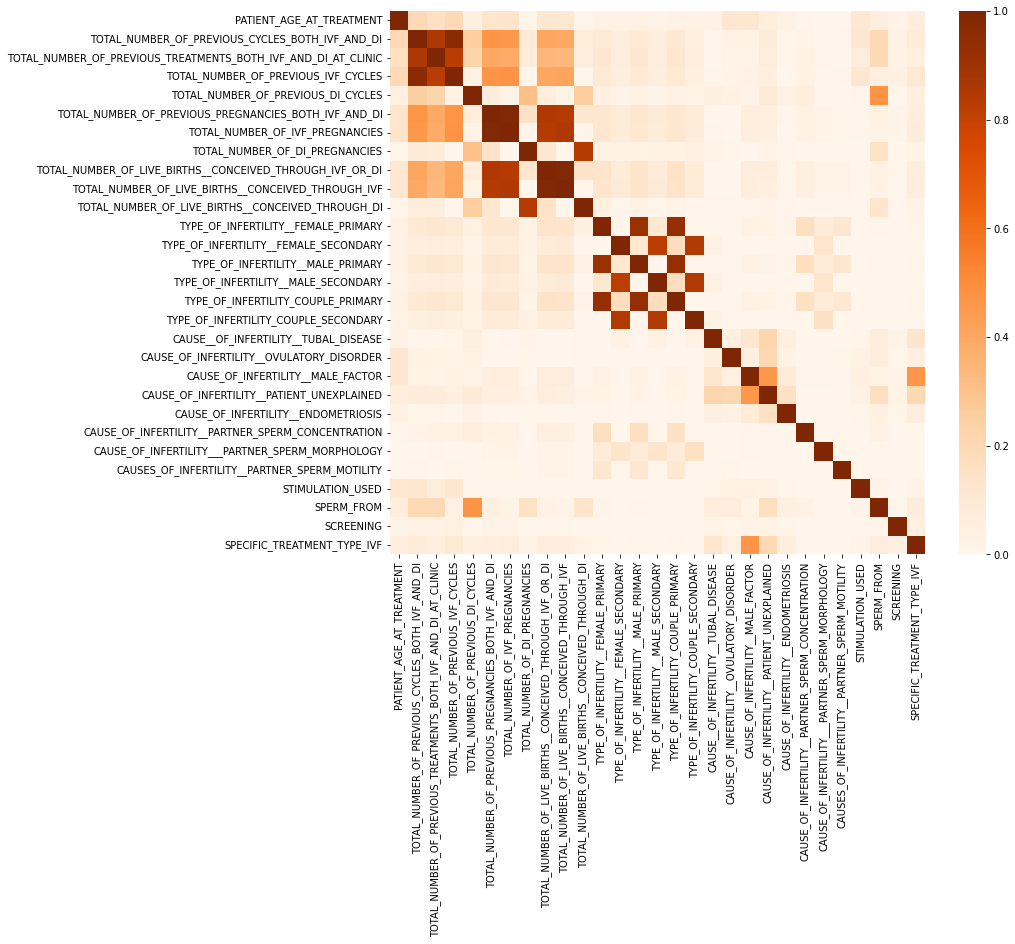

In [ ]:
correlation_df = compute_correlation_matrix(HFEA_train, binary_features, ordinal_features, count_features)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df.astype(float), annot=False, cmap='Oranges', fmt='.2f', vmin=0, vmax=1)
plt.savefig('correlation_matrix.png', bbox_inches = 'tight', dpi=600)
plt.show()

#'PuOr_r'

In [ ]:
def compute_correlation(df, binary_features, ordinal_features, count_features):
    # Initialize a list to store the correlations
    correlations = []

    columns = binary_features + ordinal_features + count_features
    
    # Loop over the DataFrame columns
    for col1 in columns:
        for col2 in columns:
            # Skip if the columns are same
            if col1 == col2:
                continue
                
            # Identify the correlation type and compute the correlation
            if col1 in binary_features and col2 in binary_features:
                correlation_type = "Phi Coefficient" # Binary X Binary (Phi)
                correlation, p_value = scipy.stats.pearsonr(df[col1], df[col2])
            elif (col1 in binary_features and col2 in ordinal_features) or \
                 (col2 in binary_features and col1 in ordinal_features):
                correlation_type = "Kendall's Tau" # Binary X Ordinal
                correlation, p_value = scipy.stats.kendalltau(df[col1], df[col2])
            elif (col1 in binary_features and col2 in count_features) or \
                 (col2 in binary_features and col1 in count_features):
                correlation_type = "Point-Biserial" # Binary X Count
                correlation, p_value = scipy.stats.pointbiserialr(df[col1], df[col2])
            elif (col1 in ordinal_features and col2 in count_features) or \
                 (col2 in ordinal_features and col1 in count_features):
                correlation_type = "Spearman" # Binary X Ordinal
                correlation, p_value = scipy.stats.spearmanr(df[col1], df[col2])
            else:
                correlation_type = "Spearman" # Ordinal X Ordinal, Ordinal X Count, Count X Count
                correlation, p_value = scipy.stats.spearmanr(df[col1], df[col2])
            
            # Append the correlation data to the list
            correlations.append([correlation_type, col1, col2, correlation, p_value])

    # Convert the list to a DataFrame
    correlation_df = pd.DataFrame(correlations, columns=['Correlation Type', 'Variable 1', 'Variable 2', 'Correlation Coefficient', 'P Value'])
    
    # Sort the DataFrame by the absolute value of the correlation coefficient
    correlation_df['abs_correlation'] = correlation_df['Correlation Coefficient'].abs()
    correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)
    
    # Drop duplicates by creating sorted pairs and comparing
    correlation_df['Variable Pair'] = correlation_df.apply(lambda x: tuple(sorted([x['Variable 1'], x['Variable 2']])), axis=1)
    correlation_df = correlation_df.drop_duplicates(subset=['Variable Pair'])
    correlation_df = correlation_df.drop(columns=['abs_correlation', 'Variable Pair'])
    
    return correlation_df


In [ ]:
correlation_rankings = compute_correlation(HFEA_train, binary_features, ordinal_features, count_features)

In [ ]:
display(correlation_rankings.head(18))

,Correlation Type,Variable 1,Variable 2,Correlation Coefficient,P Value
782,Spearman,TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH...,TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH...,0.988843,0.0
695,Spearman,TOTAL_NUMBER_OF_IVF_PREGNANCIES,TOTAL_NUMBER_OF_PREVIOUS_PREGNANCIES_BOTH_IVF_...,0.988703,0.0
607,Spearman,TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.964373,0.0
59,Phi Coefficient,TYPE_OF_INFERTILITY__MALE_PRIMARY,TYPE_OF_INFERTILITY_COUPLE_PRIMARY,0.934521,0.0
3,Phi Coefficient,TYPE_OF_INFERTILITY__FEMALE_PRIMARY,TYPE_OF_INFERTILITY_COUPLE_PRIMARY,0.928439,0.0
56,Phi Coefficient,TYPE_OF_INFERTILITY__MALE_PRIMARY,TYPE_OF_INFERTILITY__FEMALE_PRIMARY,0.910347,0.0
579,Spearman,TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_A...,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.858338,0.0
698,Spearman,TOTAL_NUMBER_OF_IVF_PREGNANCIES,TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH...,0.849856,0.0
669,Spearman,TOTAL_NUMBER_OF_PREVIOUS_PREGNANCIES_BOTH_IVF_...,TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH...,0.849617,0.0
143,Phi Coefficient,TYPE_OF_INFERTILITY_COUPLE_SECONDARY,TYPE_OF_INFERTILITY__MALE_SECONDARY,0.845054,0.0


In [ ]:
HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] = np.where(HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] > 0, 1, 0)
HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI'] = np.where(HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI'] > 0, 1, 0)
HFEA_train['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] = HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] + HFEA_train['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI']
HFEA_train['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] = np.where(HFEA_train['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] > 0, 1, 0)

HFEA_train.drop(columns=['TYPE_OF_INFERTILITY__FEMALE_PRIMARY', 'TYPE_OF_INFERTILITY__MALE_PRIMARY', 'TYPE_OF_INFERTILITY__FEMALE_SECONDARY',
'TYPE_OF_INFERTILITY__MALE_SECONDARY', 'TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_AND_DI_AT_CLINIC',
'TOTAL_NUMBER_OF_IVF_PREGNANCIES', 'TOTAL_NUMBER_OF_DI_PREGNANCIES', 'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF', 
'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI', 'TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES', 'TOTAL_NUMBER_OF_PREVIOUS_DI_CYCLES', 
'TOTAL_NUMBER_OF_PREVIOUS_PREGNANCIES_BOTH_IVF_AND_DI', 'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF_OR_DI',
'TYPE_OF_INFERTILITY_COUPLE_PRIMARY', 'TYPE_OF_INFERTILITY_COUPLE_SECONDARY', 'CAUSE_OF_INFERTILITY__PARTNER_SPERM_CONCENTRATION',
'CAUSE_OF_INFERTILITY___PARTNER_SPERM_MORPHOLOGY', 'CAUSES_OF_INFERTILITY__PARTNER_SPERM_MOTILITY'] , axis=1, inplace=True)

# Apply same processings to the test set
HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] = np.where(HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] > 0, 1, 0)
HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI'] = np.where(HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI'] > 0, 1, 0)
HFEA_test['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] = HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF'] + HFEA_test['TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI']
HFEA_test['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] = np.where(HFEA_test['PREVIOUS_LIVE_BIRTH_IVF_OR_DI'] > 0, 1, 0)

HFEA_test.drop(columns=['TYPE_OF_INFERTILITY__FEMALE_PRIMARY', 'TYPE_OF_INFERTILITY__MALE_PRIMARY', 'TYPE_OF_INFERTILITY__FEMALE_SECONDARY',
'TYPE_OF_INFERTILITY__MALE_SECONDARY', 'TOTAL_NUMBER_OF_PREVIOUS_TREATMENTS_BOTH_IVF_AND_DI_AT_CLINIC',
'TOTAL_NUMBER_OF_IVF_PREGNANCIES', 'TOTAL_NUMBER_OF_DI_PREGNANCIES', 'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF', 
'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_DI', 'TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES', 'TOTAL_NUMBER_OF_PREVIOUS_DI_CYCLES',
'TOTAL_NUMBER_OF_PREVIOUS_PREGNANCIES_BOTH_IVF_AND_DI', 'TOTAL_NUMBER_OF_LIVE_BIRTHS__CONCEIVED_THROUGH_IVF_OR_DI',
'TYPE_OF_INFERTILITY_COUPLE_PRIMARY', 'TYPE_OF_INFERTILITY_COUPLE_SECONDARY', 'CAUSE_OF_INFERTILITY__PARTNER_SPERM_CONCENTRATION',
'CAUSE_OF_INFERTILITY___PARTNER_SPERM_MORPHOLOGY', 'CAUSES_OF_INFERTILITY__PARTNER_SPERM_MOTILITY'] , axis=1, inplace=True)

In [ ]:
HFEA_train.shape

(33595, 16)

## PCA

In [ ]:
HFEA_train.columns

Index(['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
       'CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS', 'STIMULATION_USED', 'SPERM_FROM',
       'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'EMBRYOS_TRANSFERED',
       'LIVE_BIRTH_OCCURRENCE', 'SCREENING', 'SPECIFIC_TREATMENT_TYPE_IVF',
       'PREVIOUS_LIVE_BIRTH_IVF_OR_DI'],
      dtype='object')

In [ ]:
# Binary features
binary_features = [
       'PREVIOUS_LIVE_BIRTH_IVF_OR_DI',
       'CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS',
       'STIMULATION_USED', 'SCREENING', 'SPERM_FROM', 'SPECIFIC_TREATMENT_TYPE_IVF']

# Ordinal features
ordinal_features = ['PATIENT_AGE_AT_TREATMENT']

# Count features
count_features = ['TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI']

In [ ]:
correlation_rankings_new = compute_correlation(HFEA_train, binary_features, ordinal_features, count_features)

In [ ]:
correlation_rankings_new.head()

,Correlation Type,Variable 1,Variable 2,Correlation Coefficient,P Value
41,Phi Coefficient,CAUSE_OF_INFERTILITY__MALE_FACTOR,SPECIFIC_TREATMENT_TYPE_IVF,-0.467235,0.0
36,Phi Coefficient,CAUSE_OF_INFERTILITY__MALE_FACTOR,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,-0.461665,0.0
10,Point-Biserial,PREVIOUS_LIVE_BIRTH_IVF_OR_DI,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.435141,0.0
45,Phi Coefficient,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,-0.215473,0.0
46,Phi Coefficient,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,-0.211016,0.0


In [ ]:
predictors = binary_features + ordinal_features + count_features

colours_gaia = ["#FF9249", "#382C2E", '#F0E9DE']

y_list = []
for n in range(len(HFEA_train[predictors].columns)+1):
    pca = PCA(n_components=n)
    pca.fit(HFEA_train[predictors])
    y = np.sum(pca.explained_variance_ratio_)
    y_list.append(y)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(len(HFEA_train.columns))),
    y=y_list,
    mode='lines+markers',
    marker=dict(color= colours_gaia[0]),
    line=dict(dash='dash'),
    name='Cumulative variance'
))

fig.update_layout(
    template='plotly_white',
    font_family='Didot',
    title=dict(text='Proportion of Variance Explained',x=0.5,y=0.98,
               font=dict(color='black',size=16)),
    xaxis=dict(title='Number of Components', range=[0, 12]),
    yaxis=dict(title='Cumulative variance'),
    xaxis_tickmode='linear',
    xaxis_dtick=1,
    yaxis_range=[0, 1],
    showlegend=False,
)

fig.add_shape(
    type='line',
    x0=0,
    y0=0.95,
    x1=len(HFEA_train[predictors].columns),
    y1=0.95,
    line=dict(color=colours_gaia[1], width=2),
    name='95% cut-off threshold'
)
fig.add_annotation(
    x=10,
    y=0.9,
    text='95% cut-off threshold',
    showarrow=False,
    font=dict(color='black', size=12)
)

fig.show()

In [ ]:
# Refit the PCA model with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(HFEA_train[predictors])

# Extract the first, second, and third component
x = pca_result[:, 0]
y = pca_result[:, 1]
z = pca_result[:, 2]

In [ ]:
# Create a 3D scatter plot
custom_color_scale = [[0, 'rgb(254, 216, 177)'], [1, 'rgb(255, 146, 73)']]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        #color=HFEA_train['PATIENT_AGE_AT_TREATMENT'],
        #color=HFEA_train['TOTAL_NUMBER_OF_PREVIOUS_IVF_CYCLES'],  
        color=HFEA_train['LIVE_BIRTH_OCCURRENCE'],        
        colorscale=custom_color_scale,
        #colorscale='Oranges',
        opacity=1
    )
)])

# Set labels and plot title
fig.update_layout(
    scene = dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    font_family='Didot',
    #title=dict(
    #    text='Representation of PCs 1, 2, and 3',
    #    x=0.5,
    #    y=0.98,
    #    font=dict(color=colours_gaia[1], size=20)
    #),
    template="plotly_white",
    width=800,
    height=800
)

fig.show()

In [ ]:
# The variable contributions (loadings) to the components
loadings = pca.components_

# Create a DataFrame with these loadings
df_loadings = pd.DataFrame(loadings, columns=predictors, 
                           index=['PC1', 'PC2', 'PC3'])

df_loadings = df_loadings.transpose()

# For each component, print the top 5 variables
for component in df_loadings.columns:
    print("\nTop 5 contributng variables to component {}:".format(component))
    print(df_loadings[component].abs().sort_values(ascending=False).head(5))


Top 5 contributng variables to component PC1:
TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI    0.867630
PATIENT_AGE_AT_TREATMENT                           0.489508
PREVIOUS_LIVE_BIRTH_IVF_OR_DI                      0.074056
SPERM_FROM                                         0.032295
CAUSE_OF_INFERTILITY__OVULATORY_DISORDER           0.017423
Name: PC1, dtype: float64

Top 5 contributng variables to component PC2:
PATIENT_AGE_AT_TREATMENT                           0.866506
TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI    0.484913
CAUSE_OF_INFERTILITY__MALE_FACTOR                  0.072604
SPECIFIC_TREATMENT_TYPE_IVF                        0.059264
CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED          0.051113
Name: PC2, dtype: float64

Top 5 contributng variables to component PC3:
CAUSE_OF_INFERTILITY__MALE_FACTOR                  0.647225
SPECIFIC_TREATMENT_TYPE_IVF                        0.584675
CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED          0.475274
PATIENT_AGE_AT_TREATMENT   

# III. Target Analysis

In [ ]:
HFEA_train.columns

Index(['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI',
       'CAUSE__OF_INFERTILITY__TUBAL_DISEASE',
       'CAUSE_OF_INFERTILITY__OVULATORY_DISORDER',
       'CAUSE_OF_INFERTILITY__MALE_FACTOR',
       'CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED',
       'CAUSE_OF_INFERTILITY__ENDOMETRIOSIS', 'STIMULATION_USED', 'SPERM_FROM',
       'FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'EMBRYOS_TRANSFERED',
       'LIVE_BIRTH_OCCURRENCE', 'SCREENING', 'SPECIFIC_TREATMENT_TYPE_IVF',
       'PREVIOUS_LIVE_BIRTH_IVF_OR_DI'],
      dtype='object')

### III. 1. Live Birth Occurance Target

##### III. 1. a. Target Distribution

In [ ]:
fig = px.pie(HFEA_train['LIVE_BIRTH_OCCURRENCE'].value_counts(),values='LIVE_BIRTH_OCCURRENCE',names=['No Birth','Live Birth'],hole=0.4,opacity=0.7,
            color_discrete_sequence=[colours_gaia[1],colours_gaia[0]])
fig.add_annotation(text='Live Birth Rate',
                   x=0.5,y=0.5,showarrow=False,font_size=14,opacity=1,font_family='Suisse Intl')

fig.update_layout(
    font_family='Suisse Intl',
    legend=dict(x=0.37,y=-0.05,orientation='h',traceorder='reversed'),
    hoverlabel=dict(bgcolor='white'))

fig.update_traces(textposition='outside', textinfo='percent+label')

fig.show()

##### III. 1. b. Feature Correlations with Target

In [ ]:
# Temporary list to store the dictionaries
temp_list = []

# For binary predictors (Binary X Binary correlation)
for feature in binary_features:
    corr, p_value = scipy.stats.pearsonr(HFEA_train['LIVE_BIRTH_OCCURRENCE'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Phi Coefficient',
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For ordinal predictors (Binary X Ordinal)
for feature in ordinal_features:
    corr, p_value = scipy.stats.kendalltau(HFEA_train['LIVE_BIRTH_OCCURRENCE'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Kendall Tau',
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For count predictors (Binary X Count)
for feature in count_features:
    corr, p_value = scipy.stats.pointbiserialr(HFEA_train['LIVE_BIRTH_OCCURRENCE'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Rank-Biserial',
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# Create DataFrame from list of dictionaries
live_birth_corr_df = pd.DataFrame(temp_list)

# Sort and display the DataFrame
live_birth_corr_df['abs_coefficient'] = live_birth_corr_df['Coefficient Value'].abs()
live_birth_corr_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
live_birth_corr_df.drop(columns='abs_coefficient', inplace=True)

display(live_birth_corr_df)

,Coefficient Type,Variable,Coefficient Value,P Value
10,Kendall Tau,PATIENT_AGE_AT_TREATMENT,-0.186,0.000
6,Phi Coefficient,STIMULATION_USED,0.062,0.000
11,Rank-Biserial,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,-0.053,0.000
2,Phi Coefficient,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.038,0.000
9,Phi Coefficient,SPECIFIC_TREATMENT_TYPE_IVF,-0.038,0.000
3,Phi Coefficient,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.023,0.000
5,Phi Coefficient,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,0.013,0.021
1,Phi Coefficient,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.012,0.025
7,Phi Coefficient,SCREENING,-0.011,0.041
4,Phi Coefficient,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.010,0.061


### III. 2. Fresh Eggs Collected Target

#### III. 2. a. Target Distribution

In [ ]:
fig = px.histogram(HFEA_train, x='FRESH_EGGS_COLLECTED', color='LIVE_BIRTH_OCCURRENCE', template='plotly_white',
                   marginal='box', opacity=0.8, nbins=int(HFEA_train['FRESH_EGGS_COLLECTED'].max()+1),
                   color_discrete_sequence=[colours_gaia[1],colours_gaia[0]], barmode='group', histfunc='count')

fig.update_layout(
    font_family='Didot',
    title=dict(text='Oocytes Retrieved',x=0.53,y=0.95,
               font=dict(color=colours_gaia[1],size=20)),
    xaxis_title_text='Total Number of Oocytes Retrieved',
    yaxis_title_text='Count',
    legend=dict(x=0.65,y=0.65,bordercolor=colours_gaia[1],borderwidth=0,tracegroupgap=5),
    bargap=0.3,
)
fig.show()

In [ ]:
fig = px.histogram(HFEA_train, x='FRESH_EGGS_COLLECTED', color='SPECIFIC_TREATMENT_TYPE_IVF', template='plotly_white',
                   marginal='box', opacity=0.8, nbins=int(HFEA_train['FRESH_EGGS_COLLECTED'].max()+1), 
                   color_discrete_sequence=[colours_gaia[1],colours_gaia[0]], barmode='group', histfunc='count')

fig.update_layout(
    font_family='Didot',
    title=dict(text='Oocytes Retrieved',x=0.53,y=0.95,
               font=dict(color=colours_gaia[1],size=20)),
    xaxis_title_text='Total Number of Oocytes Retrieved',
    yaxis_title_text='Count',
    legend=dict(x=0.6,y=0.65,bordercolor=colours_gaia[1],borderwidth=0,tracegroupgap=5),
    bargap=0.3,
)
fig.show()

In [ ]:
corr, p_value = scipy.stats.pointbiserialr(HFEA_train['FRESH_EGGS_COLLECTED'], HFEA_train['LIVE_BIRTH_OCCURRENCE'])
print(f"Correlation (Point-Biserial) between 'FRESH_EGGS_COLLECTED' and 'LIVE_BIRTH_OCCURRENCE': {corr}")
print(f"P-value for this correlation: {p_value}")

Correlation (Point-Biserial) between 'FRESH_EGGS_COLLECTED' and 'LIVE_BIRTH_OCCURRENCE': 0.20677891343452726
P-value for this correlation: 3.617e-321


In [ ]:
mean = HFEA_train['FRESH_EGGS_COLLECTED'].mean()
variance = HFEA_train['FRESH_EGGS_COLLECTED'].var()
skewness = HFEA_train['FRESH_EGGS_COLLECTED'].skew()

print("Mean: ", mean)
print("Variance: ", variance)
print("Skewness: ", skewness)

Mean:  8.76815002232475
Variance:  36.710041094358736
Skewness:  0.9243319726245931


In [ ]:
egg_collected_nozero = HFEA_train[HFEA_train['FRESH_EGGS_COLLECTED'] != 0][['FRESH_EGGS_COLLECTED']].copy()

In [ ]:
mean = egg_collected_nozero.mean()
variance = egg_collected_nozero.var()

print("Mean: ", mean)
print("Variance: ", variance)

Mean:  FRESH_EGGS_COLLECTED    9.379589
dtype: float64
Variance:  FRESH_EGGS_COLLECTED    33.534834
dtype: float64


#### III. 2. b. Feature Correlations with Target

In [ ]:
# Temporary list to store the dictionaries
temp_list = []

# For binary predictors (Count X Binary)
for feature in binary_features:
    corr, p_value = scipy.stats.pointbiserialr(HFEA_train['FRESH_EGGS_COLLECTED'], HFEA_train[feature])
    temp_list.append({'Type': 'Rank-Biserial',
                              'Variable': feature, 'Value': round(corr,3), 'P Value': round(p_value,3)})

# For ordinal predictors (Count X Ordinal)
for feature in ordinal_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['FRESH_EGGS_COLLECTED'], HFEA_train[feature])
    temp_list.append({'Type': 'Spearman',
                              'Variable': feature, 'Value': round(corr,3), 'P Value': round(p_value,3)})

# For count predictors (Count X Count)
for feature in count_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['FRESH_EGGS_COLLECTED'], HFEA_train[feature])
    temp_list.append({'Type': 'Spearman',
                              'Variable': feature, 'Value': round(corr,3), 'P Value': round(p_value,3)})

# Create DataFrame from list of dictionaries
fresh_eggs_corr_df = pd.DataFrame(temp_list)

# Sort and display the DataFrame
fresh_eggs_corr_df['abs_coefficient'] = fresh_eggs_corr_df['Value'].abs()
fresh_eggs_corr_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
fresh_eggs_corr_df.drop(columns='abs_coefficient', inplace=True)

#cm = sns.diverging_palette(200, 37, as_cmap=True)
#display(fresh_eggs_corr_df.style.background_gradient(cmap = cm, axis=0, subset='Coefficient Value'))

display(fresh_eggs_corr_df)


,Type,Variable,Value,P Value
10,Spearman,PATIENT_AGE_AT_TREATMENT,-0.278,0.000
6,Rank-Biserial,STIMULATION_USED,0.166,0.000
9,Rank-Biserial,SPECIFIC_TREATMENT_TYPE_IVF,-0.136,0.000
2,Rank-Biserial,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.095,0.000
11,Spearman,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,-0.056,0.000
3,Rank-Biserial,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.052,0.000
5,Rank-Biserial,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,-0.033,0.000
7,Rank-Biserial,SCREENING,0.029,0.000
4,Rank-Biserial,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.012,0.031
1,Rank-Biserial,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.007,0.232


### Chi Squared Test

In [ ]:
# Assume that HFEA_train is a pandas DataFrame and FRESH_EGGS_COLLECTED is one of the columns
data = HFEA_train['FRESH_EGGS_COLLECTED']

# Calculate the lambda parameter for Poisson distribution (which is the mean of the data)
lam = data.mean()

# Get observed frequencies
observed_freq = pd.value_counts(data, sort=False)

# Calculate expected frequencies
expected_freq = poisson.pmf(observed_freq.index, lam) * len(data)

# Perform the chi-square goodness of fit test
stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

print('chi-square statistic:', stat)
print('p value:', p_value)

chi-square statistic: 9.993502231882879e+17
p value: 0.0


In [ ]:
# Assume that HFEA_train is a pandas DataFrame and FRESH_EGGS_COLLECTED is one of the columns
data = egg_collected_nozero['FRESH_EGGS_COLLECTED']

# Calculate the lambda parameter for Poisson distribution (which is the mean of the data)
lam = data.mean()

# Get observed frequencies
observed_freq = pd.value_counts(data, sort=False)

# Calculate expected frequencies
expected_freq = poisson.pmf(observed_freq.index, lam) * len(data)

# Scale the expected frequencies so they sum to the total observed frequency
expected_freq *= len(data) / expected_freq.sum()

# Perform the chi-square goodness of fit test
stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

print('chi-square statistic:', stat)
print('p value:', p_value)


chi-square statistic: 6.359912709227126e+16
p value: 0.0


### III. 3. Total Embryos Created Target

- Noticed that there was evidence that the distirbution of this target was different with respect to the live birth occurrence variable.
- Noticed that variables were slightly less correlated with this target than with the Fresh Eggs Collected target. The most correlated variables were more similar to those for live birth occurrence though.

#### III. 3. a. Target Distribution

In [ ]:
fig = px.histogram(HFEA_train, x='TOTAL_EMBRYOS_CREATED', color='LIVE_BIRTH_OCCURRENCE', template='plotly_white',
                   marginal='box', opacity=0.8, nbins=int(HFEA_train['TOTAL_EMBRYOS_CREATED'].max()+1), 
                   color_discrete_sequence=[colours_gaia[1],colours_gaia[0]], barmode='group', histfunc='count')

fig.update_layout(
    font_family='Suisse Intl',
    title=dict(text='Total Embryos Created',x=0.53,y=0.95,
               font=dict(color=colours_gaia[1],size=20)),
    xaxis_title_text='Total Embryos Created',
    yaxis_title_text='Count',
    legend=dict(x=0.65,y=0.65,bordercolor=colours_gaia[1],borderwidth=0,tracegroupgap=5),
    bargap=0.3,
)
fig.show()

In [ ]:
# assuming 'df' is your DataFrame and 'count' is your count variable
mean = HFEA_train['TOTAL_EMBRYOS_CREATED'].mean()
variance = HFEA_train['TOTAL_EMBRYOS_CREATED'].var()
skewness = HFEA_train['TOTAL_EMBRYOS_CREATED'].skew()

print("Mean: ", mean)
print("Variance: ", variance)
print("Skewness: ", skewness)

Mean:  5.100104182169966
Variance:  16.993580688080087
Skewness:  1.1175436461237556


In [ ]:
corr, p_value = scipy.stats.pointbiserialr(HFEA_train['TOTAL_EMBRYOS_CREATED'], HFEA_train['LIVE_BIRTH_OCCURRENCE'])
print(f"Correlation (Point-Biserial) between 'TOTAL_EMBRYOS_CREATED' and 'LIVE_BIRTH_OCCURRENCE': {corr}")
print(f"P-value for this correlation: {p_value}")

Correlation (Point-Biserial) between 'TOTAL_EMBRYOS_CREATED' and 'LIVE_BIRTH_OCCURRENCE': 0.24947833105070802
P-value for this correlation: 0.0


#### III. 3. b. Feature Correlations with Target

In [ ]:
# Temporary list to store the dictionaries
temp_list = []

# For binary predictors (Count X Binary)
for feature in binary_features:
    corr, p_value = scipy.stats.pointbiserialr(HFEA_train['TOTAL_EMBRYOS_CREATED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Rank-Biserial',
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For ordinal predictors (Count X Ordinal)
for feature in ordinal_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['TOTAL_EMBRYOS_CREATED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# For count predictors (Count X Count)
for feature in count_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['TOTAL_EMBRYOS_CREATED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 
                              'Variable': feature, 'Coefficient Value': round(corr,3), 'P Value': round(p_value,3)})

# Create DataFrame from list of dictionaries
embryos_created_corr_df = pd.DataFrame(temp_list)

# Sort and display the DataFrame
embryos_created_corr_df['abs_coefficient'] = embryos_created_corr_df['Coefficient Value'].abs()
embryos_created_corr_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
embryos_created_corr_df.drop(columns='abs_coefficient', inplace=True)
#cm = sns.diverging_palette(200, 37, as_cmap=True)
#display(embryos_created_corr_df.style.background_gradient(cmap = cm, axis=0, subset='Coefficient Value'))

display(embryos_created_corr_df)


,Coefficient Type,Variable,Coefficient Value,P Value
10,Spearman,PATIENT_AGE_AT_TREATMENT,-0.233,0.000
6,Rank-Biserial,STIMULATION_USED,0.121,0.000
2,Rank-Biserial,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.082,0.000
11,Spearman,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,-0.052,0.000
9,Rank-Biserial,SPECIFIC_TREATMENT_TYPE_IVF,-0.049,0.000
4,Rank-Biserial,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.040,0.000
7,Rank-Biserial,SCREENING,0.032,0.000
1,Rank-Biserial,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.025,0.000
5,Rank-Biserial,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,-0.021,0.000
8,Rank-Biserial,SPERM_FROM,0.019,0.000


### Chi Squared test

In [ ]:
embryo_nozero = HFEA_train[HFEA_train['TOTAL_EMBRYOS_CREATED'] != 0][['TOTAL_EMBRYOS_CREATED']].copy()

In [ ]:
# Assume that HFEA_train is a pandas DataFrame and FRESH_EGGS_COLLECTED is one of the columns
data = HFEA_train['TOTAL_EMBRYOS_CREATED']

# Calculate the lambda parameter for Poisson distribution (which is the mean of the data)
lam = data.mean()

# Get observed frequencies
observed_freq = pd.value_counts(data, sort=False)

# Calculate expected frequencies
expected_freq = poisson.pmf(observed_freq.index, lam) * len(data)

# Perform the chi-square goodness of fit test
stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

print('chi-square statistic:', stat)
print('p value:', p_value)

chi-square statistic: 1493378562942.0027
p value: 0.0


In [ ]:
# Assume that HFEA_train is a pandas DataFrame and FRESH_EGGS_COLLECTED is one of the columns
data = embryo_nozero['TOTAL_EMBRYOS_CREATED']

# Calculate the lambda parameter for Poisson distribution (which is the mean of the data)
lam = data.mean()

# Get observed frequencies
observed_freq = pd.value_counts(data, sort=False)

# Calculate expected frequencies
expected_freq = poisson.pmf(observed_freq.index, lam) * len(data)

# Scale the expected frequencies so they sum to the total observed frequency
expected_freq *= len(data) / expected_freq.sum()

# Perform the chi-square goodness of fit test
stat, p_value = chisquare(observed_freq, f_exp=expected_freq)

print('chi-square statistic:', stat)
print('p value:', p_value)

chi-square statistic: 58913672151.440216
p value: 0.0


### III. 4. Total Embryos Transferred

#### III. 4. a. Target Distribution

In [ ]:
fig = px.histogram(HFEA_train, x='EMBRYOS_TRANSFERED', color='LIVE_BIRTH_OCCURRENCE', template='plotly_white',
                   marginal='box', opacity=0.8, nbins=HFEA_train['EMBRYOS_TRANSFERED'].nunique(), 
                   color_discrete_sequence=[colours_gaia[1],colours_gaia[0]], barmode='group', histfunc='count')

fig.update_layout(
    font_family='Didot',
    title=dict(text='Total Embryos Transferred',x=0.53,y=0.95,
               font=dict(color=colours_gaia[1],size=20)),
    xaxis_title_text='Total Embryos Transferred',
    yaxis_title_text='Count',
    legend=dict(x=0.77,y=0.65,bordercolor=colours_gaia[1],borderwidth=0,tracegroupgap=5),
    bargap=0.3,
)
fig.show()

In [ ]:
corr, p_value = scipy.stats.pointbiserialr(HFEA_train['EMBRYOS_TRANSFERED'], HFEA_train['LIVE_BIRTH_OCCURRENCE'])
print(f"Correlation (Point-Biserial) between 'EMBRYOS_TRANSFERED' and 'LIVE_BIRTH_OCCURRENCE': {corr}")
print(f"P-value for this correlation: {p_value}")

Correlation (Point-Biserial) between 'EMBRYOS_TRANSFERED' and 'LIVE_BIRTH_OCCURRENCE': 0.10192432777811093
P-value for this correlation: 2.8327077931378037e-78


#### III. 4. b. Feature Correlations with Target

In [ ]:
# Temporary list to store the dictionaries
temp_list = []

# For binary predictors (Count X Binary)
for feature in binary_features:
    corr, p_value = scipy.stats.pointbiserialr(HFEA_train['EMBRYOS_TRANSFERED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Point-Biserial', 'Variable 1': 'EMBRYOS_TRANSFERED', 
                              'Variable 2': feature, 'Coefficient Value': corr, 'P Value': p_value})

# For ordinal predictors (Count X Ordinal)
for feature in ordinal_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['EMBRYOS_TRANSFERED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 'Variable 1': 'EMBRYOS_TRANSFERED', 
                              'Variable 2': feature, 'Coefficient Value': corr, 'P Value': p_value})

# For count predictors (Count X Count)
for feature in count_features:
    corr, p_value = scipy.stats.spearmanr(HFEA_train['EMBRYOS_TRANSFERED'], HFEA_train[feature])
    temp_list.append({'Coefficient Type': 'Spearman', 'Variable 1': 'EMBRYOS_TRANSFERED', 
                              'Variable 2': feature, 'Coefficient Value': corr, 'P Value': p_value})

# Create DataFrame from list of dictionaries
embryos_transfered_corr_df = pd.DataFrame(temp_list)

# Sort and display the DataFrame
embryos_transfered_corr_df['abs_coefficient'] = embryos_transfered_corr_df['Coefficient Value'].abs()
embryos_transfered_corr_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
embryos_transfered_corr_df.drop(columns='abs_coefficient', inplace=True)
cm = sns.diverging_palette(200, 37, as_cmap=True)
display(embryos_transfered_corr_df.style.background_gradient(cmap = cm, axis=0, subset='Coefficient Value'))


,Coefficient Type,Variable 1,Variable 2,Coefficient Value,P Value
9,Point-Biserial,EMBRYOS_TRANSFERED,SPECIFIC_TREATMENT_TYPE_IVF,-0.171200,0.000000
11,Spearman,EMBRYOS_TRANSFERED,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.168904,0.000000
10,Spearman,EMBRYOS_TRANSFERED,PATIENT_AGE_AT_TREATMENT,0.166748,0.000000
6,Point-Biserial,EMBRYOS_TRANSFERED,STIMULATION_USED,0.067673,0.000000
2,Point-Biserial,EMBRYOS_TRANSFERED,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,-0.055572,0.000000
7,Point-Biserial,EMBRYOS_TRANSFERED,SCREENING,-0.053315,0.000000
8,Point-Biserial,EMBRYOS_TRANSFERED,SPERM_FROM,0.052105,0.000000
0,Point-Biserial,EMBRYOS_TRANSFERED,PREVIOUS_LIVE_BIRTH_IVF_OR_DI,0.045420,0.000000
4,Point-Biserial,EMBRYOS_TRANSFERED,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.023204,0.000021
5,Point-Biserial,EMBRYOS_TRANSFERED,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,-0.009801,0.072443


### III. 5. Target Relationships

In [ ]:
def compute_correlation_matrix(df, binary_features, ordinal_features, count_features):
    # Initialize an empty DataFrame to store the correlations
    correlation_df = pd.DataFrame(index=df.columns, columns=df.columns)

    columns = binary_features + ordinal_features + count_features
    
    # Loop over the DataFrame columns
    for col1 in columns:
        for col2 in columns:
            # If both variables are binary, use Pearson's correlation (= Phi coeffcient)
            if col1 in binary_features and col2 in binary_features:
                correlation, _ = scipy.stats.pearsonr(df[col1], df[col2])
            # If one variable is binary and the other is ordinal, use Kendall's Tau
            elif (col1 in binary_features and col2 in ordinal_features) or \
                 (col2 in binary_features and col1 in ordinal_features):
                correlation, _ = scipy.stats.kendalltau(df[col1], df[col2])
            # If one variable is binary and the other is count, use Point-Biserial
            elif (col1 in binary_features and col2 in count_features) or \
                 (col2 in binary_features and col1 in count_features):
                correlation, _ = scipy.stats.pointbiserialr(df[col1], df[col2])
            # If one variable is ordinal and the other is count, use Spearman
            elif (col1 in ordinal_features and col2 in count_features) or \
                 (col2 in ordinal_features and col1 in count_features):
                correlation, _ = scipy.stats.spearmanr(df[col1], df[col2])
            # If both variables are ordinal or both are count, use Spearman's correlation
            else:
                correlation, _ = scipy.stats.spearmanr(df[col1], df[col2])
            
            # Store the computed correlation in the DataFrame
            correlation_df.loc[col1, col2] = correlation

    correlation_df = correlation_df.dropna(axis=0, how='all')
    correlation_df = correlation_df.dropna(axis=1, how='all')
    
    return correlation_df

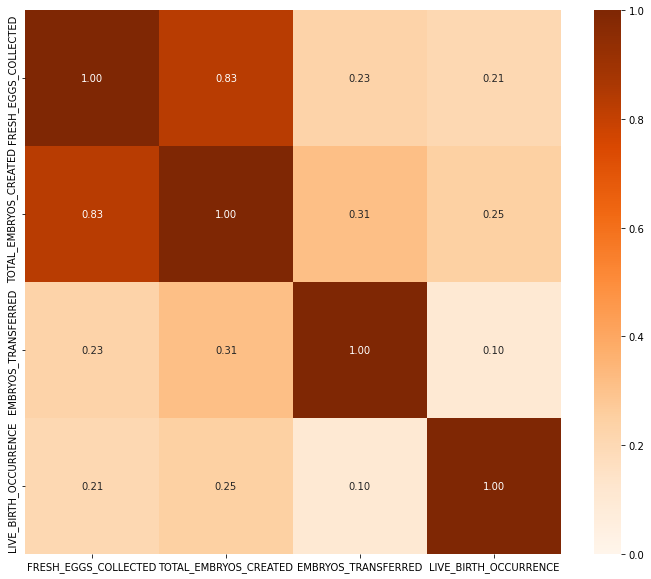

In [ ]:
HFEA_train = HFEA_train.rename(columns={'EMBRYOS_TRANSFERED': 'EMBRYOS_TRANSFERRED'})

binary_targets = ['LIVE_BIRTH_OCCURRENCE']
ordinal_targets = []
count_targets = ['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'EMBRYOS_TRANSFERRED']

correlation_df = compute_correlation_matrix(HFEA_train, binary_targets, ordinal_targets, count_targets)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df.astype(float), annot=True, cmap='Oranges', fmt='.2f', vmin=0, vmax=1)
plt.savefig('target_correlation_matrix.png', bbox_inches = 'tight', dpi=600)
plt.show()

# SAVE FILES

In [ ]:
HFEA_train = HFEA_train.drop('EMBRYOS_TRANSFERRED', axis=1)
HFEA_test = HFEA_test.drop('EMBRYOS_TRANSFERED', axis=1)

In [ ]:
HFEA_train.to_parquet('TRAIN_2016.parquet')
HFEA_test.to_parquet('TEST_2016.parquet')